**Prediction**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(224)

In [3]:
# read json for dictionary mapping
# open from json file
with open('gdrive/My Drive/MemeGenerator/dataset_final/char2idx.json', 'r', encoding = 'UTF-8') as json_file:
    char2idx = json.load(json_file)

# open from json file
with open('gdrive/My Drive/MemeGenerator/dataset_final/img2idx.json', 'r', encoding = 'UTF-8') as json_file:
    img2idx = json.load(json_file)

idx2char = {value:key for key, value in char2idx.items()}
idx2img = {value:key for key, value in img2idx.items()}

In [4]:
def get_available_devices():
    """Get IDs of all available GPUs.

    Returns:
        device (torch.device): Main device (GPU 0 or CPU).
        gpu_ids (list): List of IDs of all GPUs that are available.
    """
    gpu_ids = []
    if torch.cuda.is_available():
        gpu_ids += [gpu_id for gpu_id in range(torch.cuda.device_count())]
        device = torch.device(f'cuda:{gpu_ids[0]}')
        torch.cuda.set_device(device)
    else:
        device = torch.device('cpu')

    return device, gpu_ids

In [5]:
#### USED ONLY IF WE LOAD .pth file from save_state_dict()
def load_model(model, checkpoint_path, gpu_ids, return_step=True):
    """Load model parameters from disk.

    Args:
        model (torch.nn.DataParallel): Load parameters into this model.
        checkpoint_path (str): Path to checkpoint to load.
        gpu_ids (list): GPU IDs for DataParallel.
        return_step (bool): Also return the step at which checkpoint was saved.

    Returns:
        model (torch.nn.DataParallel): Model loaded from checkpoint.
        step (int): Step at which checkpoint was saved. Only if `return_step`.
    """
    device = "cuda:" + gpu_ids[0] if gpu_ids else 'cpu' 
    ckpt_dict = torch.load(checkpoint_path, map_location=device)

    # Build model, load parameters
    model.load_state_dict(ckpt_dict['model_state'])

    if return_step:
        step = ckpt_dict['step']
        return model, step

    return model

In [6]:
class MemeGenerator(nn.Module):
    def __init__(self):
        super(MemeGenerator, self).__init__()
        self.embedding_dim = 16
        self.img_embedding = 8
        self.num_classes = len(char2idx)
        
        # Embedding Layer for Images
        self.embedding_img = nn.Embedding(len(img2idx), self.img_embedding)
        # Embedding Layer for character embeddings
        self.embedding_layer = nn.Embedding(len(char2idx), self.embedding_dim, padding_idx = char2idx['<pad>'])
        
        # project to embedding dim
        self.project_down = nn.Linear(self.img_embedding + self.embedding_dim, self.embedding_dim)

        # convolution block
        self.conv1 = nn.Conv1d(in_channels = 16, out_channels = 1024, kernel_size = 5, padding=2)
        self.relu1 = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm1d(1024)
        self.maxpool1 = nn.MaxPool1d(kernel_size=2)
        self.dropout1 = nn.Dropout(p=0.25)

        # convolution block
        self.conv2 = nn.Conv1d(in_channels = 1024, out_channels= 1024, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU()
        self.batchnorm2 = nn.BatchNorm1d(1024)
        self.maxpool2 = nn.MaxPool1d(kernel_size=2)  # default value of stride = kernel_size
        self.dropout2 = nn.Dropout(p=0.25)

        # convolution block
        self.conv3 = nn.Conv1d(in_channels = 1024, out_channels = 1024, kernel_size = 5, padding=2)
        self.relu3 = nn.ReLU()
        self.batchnorm3 = nn.BatchNorm1d(1024)
        self.maxpool3 = nn.MaxPool1d(kernel_size=2)
        self.dropout3 = nn.Dropout(p=0.25)
        
        # convolution block
        self.conv4 = nn.Conv1d(in_channels = 1024, out_channels = 1024, kernel_size = 5, padding=2)
        self.relu4 = nn.ReLU()
        self.batchnorm4 = nn.BatchNorm1d(1024)
        self.maxpool4 = nn.MaxPool1d(kernel_size=2)
        self.dropout4 = nn.Dropout(p=0.25)

        # convolution block
        self.conv5 = nn.Conv1d(in_channels = 1024, out_channels = 1024, kernel_size = 5, padding=2)
        self.relu5 = nn.ReLU()
        self.batchnorm5 = nn.BatchNorm1d(1024)

        # final layers
        self.dropout5 = nn.Dropout(p=0.25)
        self.Linear1 = nn.Linear(1024, 1024)
        self.LinearRelu1 = nn.ReLU()
        self.batchnorm6 = nn.BatchNorm1d(1024)
        self.dropout6 = nn.Dropout(p=0.25)
        self.fc = nn.Linear(1024, self.num_classes)


    def forward(self, input_img, x):
        # input_img (batch_size)
        # x is the decoder input (batch_size, 128) where 128 is seqlen

        # input_img (batch_size, 1)
        input_img = torch.unsqueeze(input_img, dim=1)

        # need to repeat for concat (batch_size, 128) 
        input_img = input_img.repeat(1,128)
        # image embeddings (batch_size, 128, img_embedding_dim)
        img_out = self.embedding_img(input_img)

        # embedding shape (batch_size, 128, embedding_dim)
        text_out = self.embedding_layer(x)
        
        # concatenate between image and caption embeddings
        # (batch_size, 128, text_emb + img_emb)
        cat = torch.cat((img_out, text_out), dim=2)

        # project down to (batch_size, 128, 16)
        embedding_out = self.project_down(cat)

        # need to permute in order to match convnets
        # embedding shape (batch_size, embedding_dim, 128) -> (batch_size, 16, 128)
        embedding_out = embedding_out.permute(0, 2, 1)

        # apply convolution (batch_size, out_channels, 128) -> (batch_size, 1024, 128)
        conv1_out = self.conv1(embedding_out)
        conv1_out = self.relu1(conv1_out)
        # apply batchnorm -> (batch_size, 1024, 128)
        batchnorm1_out = self.batchnorm1(conv1_out)
        # apply maxpooling1 -> (batch_size, 1024, 64) kernel is 2 here
        maxpool1_out = self.maxpool1(batchnorm1_out)
        # apply dropout 1 -> (batch_size, 1024, 64)
        dropout1_out = self.dropout1(maxpool1_out)

        # apply convolution (batch_size, 1024, out_channels) -> (batch_size, 1024, 64)
        conv2_out = self.conv2(dropout1_out)
        conv2_out = self.relu2(conv2_out)
        # apply batchnorm -> (batch_size, 1024, 64)
        batchnorm2_out = self.batchnorm2(conv2_out)
        # apply maxpooling2 -> (batch_size, 1024, 32) kernel is 2 here
        maxpool2_out = self.maxpool2(batchnorm2_out)
        # apply dropout 1 -> (batch_size, 1024, 32)
        dropout2_out = self.dropout2(maxpool2_out)

        # apply convolution (batch_size, 1024, out_channels) -> (batch_size, 1024, 32)
        conv3_out = self.conv3(dropout2_out)
        conv3_out = self.relu3(conv3_out)
        # apply batchnorm -> (batch_size, 1024, 32)
        batchnorm3_out = self.batchnorm3(conv3_out)
        # apply maxpooling3 -> (batch_size, 1024, 16) kernel is 2 here
        maxpool3_out = self.maxpool3(batchnorm3_out)
        # apply dropout 1 -> (batch_size, 1024, 16)
        dropout3_out = self.dropout3(maxpool3_out)

        # apply convolution (batch_size, 1024, out_channels) -> (batch_size, 1024, 32)
        conv4_out = self.conv4(dropout3_out)
        conv4_out = self.relu4(conv4_out)
        # apply batchnorm -> (batch_size, 1024, 16)
        batchnorm4_out = self.batchnorm4(conv4_out)
        # apply maxpooling4 -> (batch_size, 1024, 8) kernel is 2 here
        maxpool4_out = self.maxpool4(batchnorm4_out)
        # apply dropout 1 -> (batch_size, 1024, 8)
        dropout4_out = self.dropout4(maxpool4_out)

        # apply convolution (batch_size, 1024, out_channels) -> (batch_size, 1024, 8)
        conv5_out = self.conv5(dropout4_out)
        conv5_out = self.relu5(conv5_out)
        # apply batchnorm -> (batch_size, 1024, 8)
        batchnorm5_out = self.batchnorm5(conv5_out)

        # Global MaxPooling1d shape (batch_size, 1024)
        # this takes maximum among all channels
        gmaxpool_out = torch.max(batchnorm5_out, dim=2)
        gmaxpool_out = gmaxpool_out.values
        gmaxpool_out = self.dropout5(gmaxpool_out)

        # apply dense layer (batch_size, 1024)
        linear_out = self.Linear1(gmaxpool_out)
        linear_out = self.LinearRelu1(linear_out)
        batchnorm6_out = self.batchnorm6(linear_out)
        dropout6_out = self.dropout6(batchnorm6_out)

        final = self.fc(dropout6_out)

        return final

In [7]:
def setup_model():
    # load model
    device, gpu_ids = get_available_devices()

    # load from final model
    # model = torch.jit.load("gdrive/My Drive/Yelp_Sentiment_Analysis/best-model-180000.pth")

    # load from state_dict
    model = load_model(MemeGenerator(), 'gdrive/My Drive/MemeGenerator/save/train/baseline-02/step_40002497.pth.tar', gpu_ids, return_step=False)

    model = model.to(device)
    model.eval()

    return model, device

**Decoding Algorithm**
- Greedy
  - Take best character at every time step and proceed
- Sampling
  - Randomly sample based on the probabilities at each time step 
- Beam Search
  - at each time step take k best output
  - Algorithm:
    - First generate k predictions with scores
    - Take each prediction and generate k more predictions at each time step from the previous output until we reach k end candidates. Score will be current score P(Y|X) * prev score P(X) = P(X,Y)
    - Iterate until we reach k end candidates
    - Take output (with end token) that has highest score. 

In [8]:
def do_prediction(device, model, img_num, prediction_mode, beam_width = 3, maxcharpred = 250, test_string = ""):
    # device = device to predict on "cpu" or "cuda:0" for GPU
    # model = character model
    # img_num = encoded image number (0-98)
    # prediction_mode = "greedy", "sampling", "beam"
    # beam_width = parameter of beam search
    # maxcharpred = maximum character length of predictions
    # test_string = starter string for meme

    # Opening Image
    img = plt.imread('gdrive/My Drive/MemeGenerator/img/' + idx2img[img_num] + '.jpg')
    plt.imshow(img)
    
    ### Method to preprocess input for padding
    def preprocess_input(test_string):
        # convert string to number array
        test_string_proc = [char2idx["<start>"]]
        # add any test string
        for char in test_string:
            test_string_proc.append(char2idx[char])

        # add the prepadding
        currlen = len(test_string_proc)
        rem = 128 - currlen
        for i in range(rem):
            test_string_proc.insert(0, 0)
        return test_string_proc

    # apply method
    # test_string_proc (list of length number of input string)
    test_string_proc = preprocess_input(test_string)

    # keep text generated
    text_generated = [char2idx["<start>"]]
    # add any other from test string
    for elem in test_string:
        text_generated.append(char2idx[elem])

    # Starter string
    input_eval = torch.tensor(test_string_proc).to(device)
    input_eval = input_eval.unsqueeze(0)
    
    # create input image
    # input_img size ([1])
    input_img = torch.zeros(1).long() 
    input_img[0] = img_num # Pick Images
    input_img = input_img.to(device)

    # just for beam search scores
    beam_table = pd.DataFrame()
    beam_candidates = []

    if prediction_mode == "greedy" or prediction_mode == "sampling":
        # iterate until maximum length
        for i in range(maxcharpred):
            # if current sequences is less than 128
            if len(text_generated) < 128:
                currlen = len(text_generated)
                rem = 128 - currlen
                input_eval = text_generated.copy()
                # prepadding
                for i in range(rem):
                    input_eval.insert(0, 0)

            # if greater than 128, take only last 128
            else:
                input_eval = text_generated.copy()
                input_eval = input_eval[-128:]

            # convert input to tensors
            input_eval = torch.tensor(input_eval).to(device)
            input_eval = input_eval.unsqueeze(0)

            # predict from inputs
            predictions = model(input_img, input_eval)

            # apply softmax to make probabilities
            softmax_layer = nn.Softmax(dim=1)
            predictions = softmax_layer(predictions)

            # Greedy mode 
            if prediction_mode == "greedy":
                best_char = torch.max(predictions, dim=1).indices
                text_generated.append(best_char.item())
                # if predict <end> break loop
                if best_char.item() == char2idx['<end>']:
                    break

            # Sampling mode (based on the probabilities generated)
            elif prediction_mode == "sampling":
                # convert to numpy
                predictions = predictions.detach().cpu().numpy()
                # randomly choose based on probability
                predicted_id = np.random.choice(len(char2idx), size = 1, replace = False, p = predictions[predictions.shape[0] - 1])
                # save generated chars
                text_generated.append(predicted_id[0])
                # if predict end token
                if predicted_id[0] == char2idx['<end>']:
                    break
    
        final = ''
        final += ''.join([idx2char[elem] for elem in text_generated])
        print(final)
        return None
    
    # Beam Search
    elif prediction_mode == "beam":
        # Beam Search Prediction
        def predict_beam_search(input_seq):
            # if current sequences is less than 128
            if len(input_seq) < 128:
                currlen = len(input_seq)
                rem = 128 - currlen
                input_eval = input_seq.copy()
                # prepadding
                for i in range(rem):
                    input_eval.insert(0, 0)

            # if greater than 128, take only last 128
            else:
                input_eval = input_seq.copy()
                input_eval = input_eval[-128:]

            # convert input to tensors
            input_eval = torch.tensor(input_eval).to(device)
            input_eval = input_eval.unsqueeze(0)

            # predict from inputs
            predictions = model(input_img, input_eval)

            # apply softmax to make probabilities
            softmax_layer = nn.Softmax(dim=1)
            predictions = softmax_layer(predictions)

            # convert to numpy
            predictions = list(predictions.detach().cpu().numpy().ravel())
            # Take top k scores
            indexes = sorted(range(len(predictions)), key=lambda i: predictions[i])[-beam_width:]
            scores = [predictions[elem] for elem in indexes]
            return indexes, scores


        #### First Iteration of Beam Search
        indexes, scores = predict_beam_search(text_generated)
        # add to df for bookeeping
        col_a = []
        col_b= []      
        for idx, elem in enumerate(indexes):
            beam_temp = text_generated.copy()
            beam_temp.append(elem)
            col_a.append(beam_temp)
            col_b.append(scores[idx])
            beam_candidates.append(beam_temp)

        temp_df = pd.DataFrame()
        temp_df['candidates'] = col_a
        temp_df['score'] = col_b
        beam_table = beam_table.append(temp_df)
        #######

        # Method for bookeeping
        def bookkeep(indexes, scores, curr):
          col_a = []
          col_b= []      
          for idx, elem in enumerate(indexes):
              beam_temp = curr.copy()
              beam_temp.append(elem)
              col_a.append(beam_temp)
              col_b.append(scores[idx])

          temp_df = pd.DataFrame()
          temp_df['candidates'] = col_a
          temp_df['score'] = col_b
          return temp_df

        count_done = 0
        ### Beam Search
        while count_done != beam_width:
            sec_df = pd.DataFrame()
            while len(beam_candidates) != 0:
                curr = beam_candidates.pop()
                indexes, scores = predict_beam_search(curr)
                temp_df = bookkeep(indexes, scores, curr)
                sec_df = sec_df.append(temp_df, ignore_index=True)

            # take top k in pandas dataframe 
            sec_df = sec_df.sort_values(by=['score'], ascending = False).reset_index(drop = True)
            sec_df = sec_df.loc[0:(beam_width - count_done - 1),:]

            # Multiply Scores and place candidates in beam candidates array
            for i in range((beam_width-count_done)):
                curr_score = sec_df.loc[i, 'score']
                curr_arr = sec_df.loc[i, 'candidates']
                # get past score and multiply since it is conditional probability
                m = beam_table['candidates'].apply(lambda x: x == curr_arr[:-1])
                prev_score = beam_table.loc[m, :].loc[:, 'score'].values
                sec_df.loc[i, 'score'] = curr_score * prev_score[0]

                # last elem check -> If <end> add to count_done to reduce candidates
                if curr_arr[-1] == char2idx["<end>"]:
                    count_done += 1
                else:
                    # add to candidates
                    beam_candidates.append(curr_arr)


            # append all candidates to master table
            beam_table = beam_table.append(sec_df, ignore_index = True)

        # filter only those with end token
        def has_endtoken(x):
            if char2idx["<end>"] in x:
                return True
            else:
                return False
        beam_table['contains_end'] = beam_table['candidates'].apply(lambda x: has_endtoken(x))
        beam_table = beam_table[beam_table['contains_end'] == True]

        # sort by scores
        beam_table = beam_table.sort_values(by=['score'], ascending = False)
        
        final = '' 
        final += ''.join([idx2char[elem] for elem in beam_table.iloc[0, 0] ])
        print(final)
        return None

In [9]:
# setup model
model, device = setup_model()

<start>spiders up to a new meow for checking the end of ninja<sep>accovid-19<end>


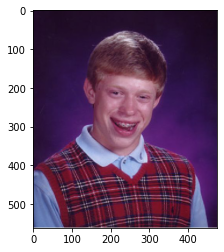

In [10]:
test_string = ""
do_prediction(device, model, img_num = 10, prediction_mode = "beam", beam_width = 3)

In [11]:
idx2img

{0: '10-Guy',
 1: 'Aaaaand-Its-Gone',
 2: 'Aint-Nobody-Got-Time-For-That',
 3: 'Am-I-The-Only-One-Around-Here',
 4: 'American-Chopper-Argument',
 5: 'Ancient-Aliens',
 6: 'And-everybody-loses-their-minds',
 7: 'Archer',
 8: 'Awkward-Moment-Sealion',
 9: 'Back-In-My-Day',
 10: 'Bad-Luck-Brian',
 11: 'Bad-Pun-Dog',
 12: 'Batman-Slapping-Robin',
 13: 'Be-Like-Bill',
 14: 'Bernie-I-Am-Once-Again-Asking-For-Your-Support',
 15: 'Black-Girl-Wat',
 16: 'Blank-Nut-Button',
 17: 'Boardroom-Meeting-Suggestion',
 18: 'Brace-Yourselves-X-is-Coming',
 19: 'But-Thats-None-Of-My-Business',
 20: 'Captain-Picard-Facepalm',
 21: 'Change-My-Mind',
 22: 'Confession-Bear',
 23: 'Conspiracy-Keanu',
 24: 'Creepy-Condescending-Wonka',
 25: 'Disaster-Girl',
 26: 'Doge',
 27: 'Dont-You-Squidward',
 28: 'Dr-Evil-Laser',
 29: 'Drake-Hotline-Bling',
 30: 'Epic-Handshake',
 31: 'Evil-Kermit',
 32: 'Evil-Toddler',
 33: 'Expanding-Brain',
 34: 'Face-You-Make-Robert-Downey-Jr',
 35: 'Finding-Neverland',
 36: 'First-Wor